In [1]:
from neural_network import MLBioNN
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
from PIL import Image

from lime import lime_image
from skimage.segmentation import mark_boundaries

import matplotlib.pyplot as plt

In [2]:
LESION_TYPE = {
    0: 'Melanocytic nevi',
    1: 'dermatofibroma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

In [3]:
model = MLBioNN(len(LESION_TYPE))
model.load_state_dict(torch.load("model_mlbio_cpu.pth"))

<All keys matched successfully>

In [10]:
transormations = transforms.Compose([
    transforms.ToTensor(), # Scale image to [0, 1]
])

In [4]:
img = "/Users/moustaphadiop/Downloads/archive/HAM10000_images_part_1/ISIC_0024343.jpg"

In [5]:
def load_image(path):
    img = Image.open(path)
    return img

In [11]:
class ExplainResults:
    def __init__(self, torch_model, transform, lesion_type):
        self.lesion_type = lesion_type
        self.torch_model = torch_model
        self.transform = transform
        
        self.explainer = lime_image.LimeImageExplainer()
        
    def batch_prediction(self, images):
        batch = torch.stack(tuple(self.transform(i) for i in images), dim=0)
        self.torch_model.eval()
        
        with torch.no_grad():
            pred = self.torch_model(batch)
            proba = F.softmax(pred, dim=1)

            return proba.numpy()
        
    def prediction(self, image, explain=False):
        probs = self.batch_prediction([image])
        val = probs.argmax()
        lesion = (self.lesion_type.get(val), probs[0][val])
        
        if explain:
            explanation = self.explainer.explain_instance(np.array(image), 
                                                          self.batch_prediction, # classification function
                                                          top_labels=1,
                                                          hide_color=0,
                                            s              num_samples=100) # number of images that will be sent to classification function
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
            return lesion, mark_boundaries(temp/255.0, mask)
        
        return lesion, None

In [12]:
explain_model = ExplainResults(model, transormations, LESION_TYPE)

In [13]:
lesion, ex = explain_model.prediction(load_image(img), True)

  0%|          | 0/100 [00:00<?, ?it/s]

('Melanocytic nevi', 0.965291)


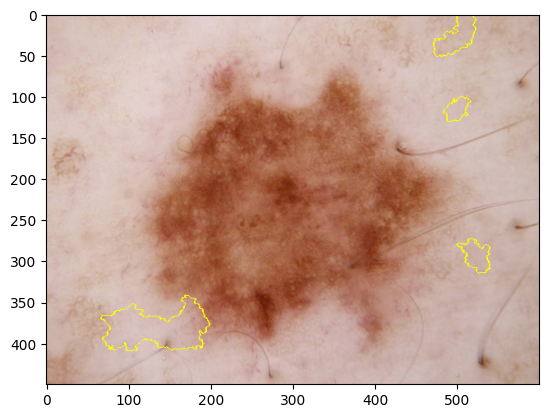

In [14]:
print(lesion)
plt.imshow(ex)
plt.show()